In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Concatenate
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# установка параметров нейросети
BATCH_SIZE = 16
BUFFER_SIZE = 128
epochs = 10

In [3]:
dataset, info = tfds.load('horses_or_humans', with_info=True)

In [4]:
dataset

{'train': <PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [5]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='C:\\Users\\snetkova\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [6]:
def normalize_c(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #label -= 1
    return input_image, label

In [7]:
def load_image_train_c(datapoint):
    input_image = tf.image.resize(datapoint['image'],(128,128))
    label = datapoint['label']

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)


    input_image, label = normalize_c(input_image, label)

    return input_image, label

def load_image_test_c(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = label = datapoint['label']

    input_image, label = normalize_c(input_image, label)

    return input_image, label 

In [8]:
train = dataset['train'].map(load_image_train_c)
test = dataset['test'].map(load_image_test_c)

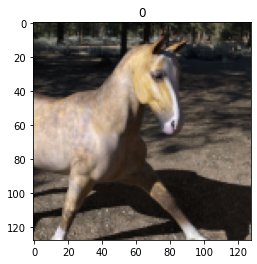

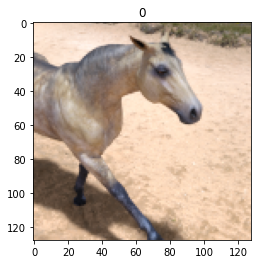

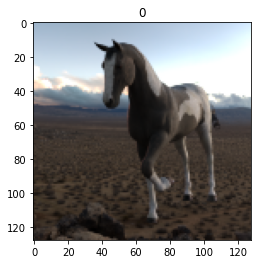

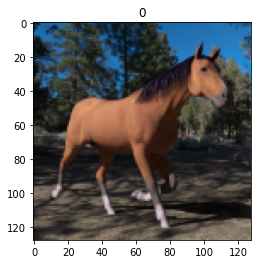

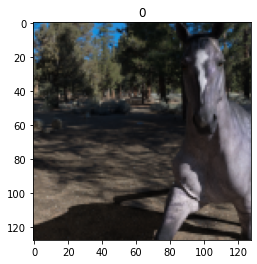

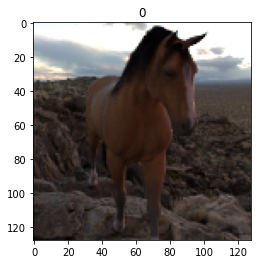

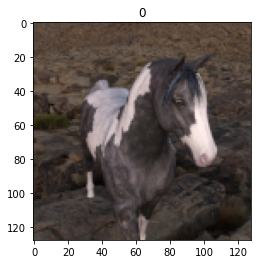

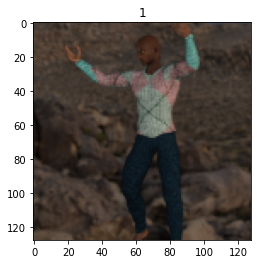

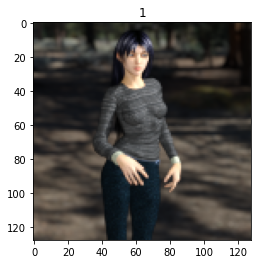

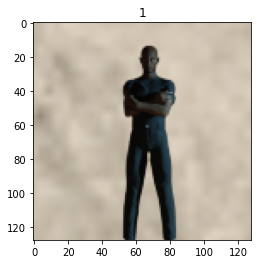

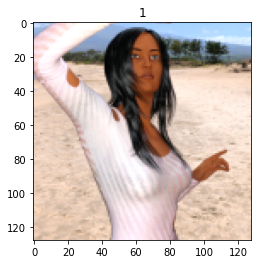

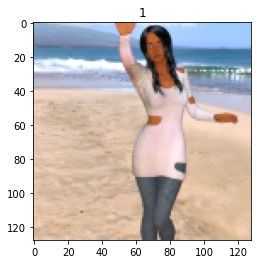

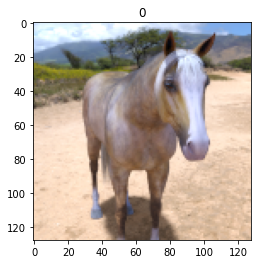

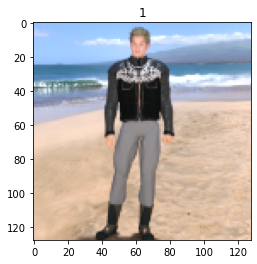

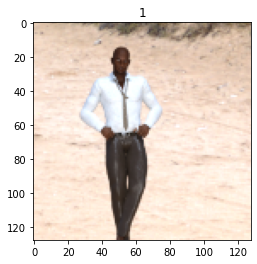

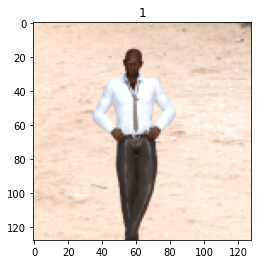

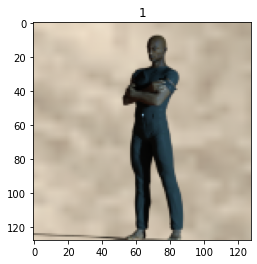

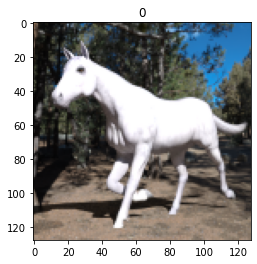

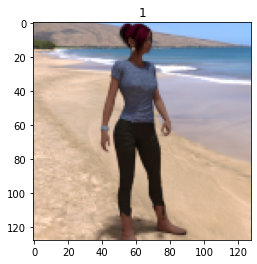

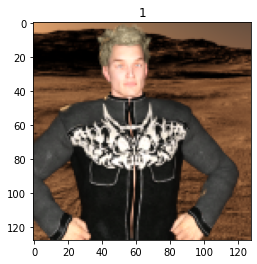

In [9]:
for image, label in train.take(20):
    sample_image, sample_label = image, label
    plt.imshow(sample_image.numpy()[:,:,:])
    plt.title(sample_label.numpy())
    plt.show()

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train.batch(BATCH_SIZE)

In [11]:
test_dataset = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
classes = ['horse', 'human']

In [13]:
res = {}

### model

In [14]:
# инициализация  модели
l_dim = 2
image_size = (image.shape[0], image.shape[1], image.shape[2])

e_inputs = keras.Input(shape=image_size)
x = layers.Conv2D(64, kernel_size=(7, 7), strides=(4, 3), activation='relu',  padding="same")(e_inputs)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(192, kernel_size=(5, 5), strides=(1, 1), activation='relu',  padding="same")(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
x = layers.Flatten()(x)
x = layers.Dense(84, activation='tanh')(x)
x = layers.Dense(l_dim)(x)

model1 = keras.Model(e_inputs, x, name="classifier")
model1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model1.summary()
model1.save_weights('model1.h5')

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 43, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 22, 192)       307392    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 11, 192)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 11, 256)        442624    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 10, 256)        0

In [15]:
model1.load_weights('model1.h5')
model_history = model1.fit(train_dataset,
                  batch_size=BATCH_SIZE,
                  epochs=epochs,
                  validation_data=(test_dataset),
                  shuffle=True
                 )

Epoch 1/10
65/65 [==============================] - 7s 108ms/step - loss: 0.8124 - accuracy: 0.6594 - val_loss: 1.0277 - val_accuracy: 0.7891
Epoch 2/10
65/65 [==============================] - 6s 98ms/step - loss: 0.1790 - accuracy: 0.9392 - val_loss: 0.4186 - val_accuracy: 0.8984
Epoch 3/10
65/65 [==============================] - 6s 99ms/step - loss: 0.1230 - accuracy: 0.9530 - val_loss: 1.4394 - val_accuracy: 0.8008
Epoch 4/10
65/65 [==============================] - 6s 100ms/step - loss: 0.1004 - accuracy: 0.9584 - val_loss: 0.7734 - val_accuracy: 0.8672
Epoch 5/10
65/65 [==============================] - 7s 101ms/step - loss: 0.0825 - accuracy: 0.9706 - val_loss: 0.6691 - val_accuracy: 0.8828
Epoch 6/10
65/65 [==============================] - 7s 101ms/step - loss: 0.0274 - accuracy: 0.9903 - val_loss: 1.5531 - val_accuracy: 0.7227
Epoch 7/10
65/65 [==============================] - 7s 101ms/step - loss: 0.0570 - accuracy: 0.9689 - val_loss: 0.2741 - val_accuracy: 0.9336
Epoch 8/

In [16]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
res['model'] = [acc[-1], val_acc[-1]]

In [17]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.0,0.824219


In [18]:
def create_model(loss, optimizer):
    l_dim = 2
    image_size = (image.shape[0], image.shape[1], image.shape[2])

    e_inputs = keras.Input(shape=image_size)
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(4, 3), activation='relu',  padding="same")(e_inputs)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(192, kernel_size=(5, 5), strides=(1, 1), activation='relu',  padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(84, activation='tanh')(x)
    x = layers.Dense(l_dim)(x)

    model = keras.Model(e_inputs, x, name="classifier")
    model.compile(loss = loss, optimizer =optimizer, metrics=['accuracy'])
  
    
    return model

### epochs

In [21]:
for e in [20, 40, 60]:
    model = create_model(tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), 'adam')
    model.load_weights('model1.h5')
    model_history = model.fit(train_dataset,
                  batch_size=BATCH_SIZE,
                  epochs=e,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    res['epochs' + str(e)] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 7s 95ms/step - loss: 0.8802 - accuracy: 0.6446 - val_loss: 1.0673 - val_accuracy: 0.8398
Epoch 2/20
65/65 [==============================] - 6s 99ms/step - loss: 0.1931 - accuracy: 0.9239 - val_loss: 0.6925 - val_accuracy: 0.8477
Epoch 3/20
65/65 [==============================] - 7s 100ms/step - loss: 0.1135 - accuracy: 0.9554 - val_loss: 0.6076 - val_accuracy: 0.8828
Epoch 4/20
65/65 [==============================] - 6s 100ms/step - loss: 0.0622 - accuracy: 0.9739 - val_loss: 0.4961 - val_accuracy: 0.8945
Epoch 5/20
65/65 [==============================] - 7s 101ms/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.7297 - val_accuracy: 0.8711
Epoch 6/20
65/65 [==============================] - 7s 106ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.6334 - val_accuracy: 0.8984
Epoch 7/20
65/65 [==============================] - 7s 106ms/step - loss: 0.0252 - accuracy: 0.9907 - val_loss: 1.6350 - val_accuracy: 0.7695
Epoch 8/

Epoch 38/40
65/65 [==============================] - 7s 103ms/step - loss: 2.1076e-05 - accuracy: 1.0000 - val_loss: 1.0989 - val_accuracy: 0.8789
Epoch 39/40
65/65 [==============================] - 7s 102ms/step - loss: 2.8968e-05 - accuracy: 1.0000 - val_loss: 1.1038 - val_accuracy: 0.8789
Epoch 40/40
65/65 [==============================] - 7s 104ms/step - loss: 2.5944e-05 - accuracy: 1.0000 - val_loss: 1.1075 - val_accuracy: 0.8789
Epoch 1/60
65/65 [==============================] - 7s 106ms/step - loss: 0.8508 - accuracy: 0.6464 - val_loss: 0.6675 - val_accuracy: 0.8555
Epoch 2/60
65/65 [==============================] - 7s 103ms/step - loss: 0.2108 - accuracy: 0.9208 - val_loss: 0.5769 - val_accuracy: 0.8516
Epoch 3/60
65/65 [==============================] - 7s 104ms/step - loss: 0.1527 - accuracy: 0.9419 - val_loss: 0.6740 - val_accuracy: 0.8398
Epoch 4/60
65/65 [==============================] - 7s 104ms/step - loss: 0.0561 - accuracy: 0.9845 - val_loss: 1.1183 - val_accuracy

65/65 [==============================] - 7s 106ms/step - loss: 5.2804e-06 - accuracy: 1.0000 - val_loss: 1.2815 - val_accuracy: 0.8477
Epoch 55/60
65/65 [==============================] - 7s 108ms/step - loss: 6.9957e-06 - accuracy: 1.0000 - val_loss: 1.2721 - val_accuracy: 0.8477
Epoch 56/60
65/65 [==============================] - 7s 106ms/step - loss: 5.9962e-06 - accuracy: 1.0000 - val_loss: 1.2772 - val_accuracy: 0.8477
Epoch 57/60
65/65 [==============================] - 7s 106ms/step - loss: 6.8984e-06 - accuracy: 1.0000 - val_loss: 1.3265 - val_accuracy: 0.8477
Epoch 58/60
65/65 [==============================] - 7s 104ms/step - loss: 5.3470e-06 - accuracy: 1.0000 - val_loss: 1.3332 - val_accuracy: 0.8477
Epoch 59/60
65/65 [==============================] - 7s 106ms/step - loss: 6.7435e-06 - accuracy: 1.0000 - val_loss: 1.2936 - val_accuracy: 0.8477
Epoch 60/60
65/65 [==============================] - 7s 109ms/step - loss: 4.9608e-06 - accuracy: 1.0000 - val_loss: 1.3049 - val_

In [22]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656


модель переобучается, больше 20 эпох смысла делать нет

### batch_size

In [23]:
for bs in [8, 32, 64]:
    model1 = create_model(tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), Adam())
    model1.load_weights('model1.h5')
    model_history = model1.fit(train_dataset,
                  batch_size=bs,
                  epochs=20,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    res['batch' + str(bs)] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 6s 96ms/step - loss: 0.8404 - accuracy: 0.6582 - val_loss: 0.9313 - val_accuracy: 0.8281
Epoch 2/20
65/65 [==============================] - 6s 96ms/step - loss: 0.1707 - accuracy: 0.9290 - val_loss: 0.7623 - val_accuracy: 0.8516
Epoch 3/20
65/65 [==============================] - 6s 98ms/step - loss: 0.1431 - accuracy: 0.9544 - val_loss: 0.4703 - val_accuracy: 0.8789
Epoch 4/20
65/65 [==============================] - 6s 98ms/step - loss: 0.1223 - accuracy: 0.9530 - val_loss: 0.9849 - val_accuracy: 0.8125
Epoch 5/20
65/65 [==============================] - 7s 100ms/step - loss: 0.0267 - accuracy: 0.9903 - val_loss: 1.2556 - val_accuracy: 0.8008
Epoch 6/20
65/65 [==============================] - 7s 101ms/step - loss: 0.0282 - accuracy: 0.9877 - val_loss: 0.7234 - val_accuracy: 0.8984
Epoch 7/20
65/65 [==============================] - 7s 102ms/step - loss: 0.0735 - accuracy: 0.9699 - val_loss: 0.6598 - val_accuracy: 0.8633
Epoch 8/20

65/65 [==============================] - 7s 105ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.8187 - val_accuracy: 0.8555
Epoch 19/20
65/65 [==============================] - 7s 106ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.6235 - val_accuracy: 0.8945
Epoch 20/20
65/65 [==============================] - 7s 105ms/step - loss: 0.0448 - accuracy: 0.9829 - val_loss: 0.4022 - val_accuracy: 0.9141


In [24]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656
batch8,0.998053,0.917969
batch32,1.000000,0.933594
batch64,0.981499,0.914062


Возьмем 32

### model add layers

In [25]:
# инициализация  модели
l_dim = 2
image_size = (image.shape[0], image.shape[1], image.shape[2])

e_inputs = keras.Input(shape=image_size)
x = layers.Conv2D(64, kernel_size=(7, 7), strides=(4, 3), activation='relu',  padding="same")(e_inputs)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(192, kernel_size=(5, 5), strides=(1, 1), activation='relu',  padding="same")(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
x = layers.Flatten()(x)
x = layers.Dense(84, activation='tanh')(x)
x = layers.Dense(l_dim)(x)

model2 = keras.Model(e_inputs, x, name="classifier2")
model2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model2.summary()
model2.save_weights('model2.h5')

Model: "classifier2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 43, 64)        9472      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 22, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 22, 192)       307392    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 11, 192)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 11, 384)        663936    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 11, 384)        

In [26]:
model2.load_weights('model2.h5')
model_history = model2.fit(train_dataset,
                  batch_size=32,
                  epochs=20,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
res['layers'] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 14s 209ms/step - loss: 0.9149 - accuracy: 0.5325 - val_loss: 1.0860 - val_accuracy: 0.5352
Epoch 2/20
65/65 [==============================] - 14s 212ms/step - loss: 0.3185 - accuracy: 0.8505 - val_loss: 0.5056 - val_accuracy: 0.8633
Epoch 3/20
65/65 [==============================] - 14s 219ms/step - loss: 0.2245 - accuracy: 0.9199 - val_loss: 0.6731 - val_accuracy: 0.8320
Epoch 4/20
65/65 [==============================] - 15s 228ms/step - loss: 0.2131 - accuracy: 0.9204 - val_loss: 0.9032 - val_accuracy: 0.7969
Epoch 5/20
65/65 [==============================] - 15s 224ms/step - loss: 0.1009 - accuracy: 0.9626 - val_loss: 0.7523 - val_accuracy: 0.8359
Epoch 6/20
65/65 [==============================] - 15s 225ms/step - loss: 0.1050 - accuracy: 0.9586 - val_loss: 2.0741 - val_accuracy: 0.5742
Epoch 7/20
65/65 [==============================] - 15s 228ms/step - loss: 0.0551 - accuracy: 0.9844 - val_loss: 0.7344 - val_accuracy: 0.7461

In [27]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656
batch8,0.998053,0.917969
batch32,1.000000,0.933594
batch64,0.981499,0.914062
layers,0.983447,0.753906


Добавление двух сверточных слоев снизило точность на тесте

### model add kernels

In [28]:
# инициализация  модели
l_dim = 2
image_size = (image.shape[0], image.shape[1], image.shape[2])

e_inputs = keras.Input(shape=image_size)
x = layers.Conv2D(128, kernel_size=(7, 7), strides=(4, 3), activation='relu',  padding="same")(e_inputs)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(384, kernel_size=(5, 5), strides=(1, 1), activation='relu',  padding="same")(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
x = layers.Flatten()(x)
x = layers.Dense(168, activation='tanh')(x)
x = layers.Dense(l_dim)(x)

model3 = keras.Model(e_inputs, x, name="classifier")
model3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model3.summary()
model3.save_weights('model3.h5')

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 43, 128)       18944     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 22, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 22, 384)       1229184   
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 11, 384)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 11, 512)        1769984   
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 10, 512)        0

In [29]:
model3.load_weights('model3.h5')
model_history = model3.fit(train_dataset,
                  batch_size=32,
                  epochs=20,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
res['kernels'] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 21s 319ms/step - loss: 1.6233 - accuracy: 0.5322 - val_loss: 1.3131 - val_accuracy: 0.7539
Epoch 2/20
65/65 [==============================] - 21s 319ms/step - loss: 0.2276 - accuracy: 0.9111 - val_loss: 0.3689 - val_accuracy: 0.9023
Epoch 3/20
65/65 [==============================] - 21s 323ms/step - loss: 0.2199 - accuracy: 0.9085 - val_loss: 0.7028 - val_accuracy: 0.8359
Epoch 4/20
65/65 [==============================] - 21s 322ms/step - loss: 0.1104 - accuracy: 0.9636 - val_loss: 0.8116 - val_accuracy: 0.8750
Epoch 5/20
65/65 [==============================] - 21s 322ms/step - loss: 0.0475 - accuracy: 0.9800 - val_loss: 0.3869 - val_accuracy: 0.9219
Epoch 6/20
65/65 [==============================] - 21s 323ms/step - loss: 0.0831 - accuracy: 0.9673 - val_loss: 0.5754 - val_accuracy: 0.9023
Epoch 7/20
65/65 [==============================] - 21s 325ms/step - loss: 0.0506 - accuracy: 0.9811 - val_loss: 1.0286 - val_accuracy: 0.8594

In [30]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656
batch8,0.998053,0.917969
batch32,1.000000,0.933594
batch64,0.981499,0.914062
layers,0.983447,0.753906
kernels,1.000000,0.878906


увеличение количества ядер тоже снизило метрику

### optimizer

In [39]:
for opt in [RMSprop(), SGD(), Adam(), Nadam()]:
    model5 = create_model(tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), opt)
    model5.load_weights('model1.h5')
    model_history = model5.fit(train_dataset,
                  batch_size=32,
                  epochs=20,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    res['opt_' + str(opt)] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 7s 107ms/step - loss: 2.0368 - accuracy: 0.5335 - val_loss: 0.5667 - val_accuracy: 0.7070
Epoch 2/20
65/65 [==============================] - 7s 109ms/step - loss: 0.4036 - accuracy: 0.8279 - val_loss: 0.4115 - val_accuracy: 0.8711
Epoch 3/20
65/65 [==============================] - 7s 110ms/step - loss: 0.2465 - accuracy: 0.9204 - val_loss: 0.6627 - val_accuracy: 0.8047
Epoch 4/20
65/65 [==============================] - 7s 115ms/step - loss: 0.3096 - accuracy: 0.8917 - val_loss: 0.4913 - val_accuracy: 0.8828
Epoch 5/20
65/65 [==============================] - 8s 118ms/step - loss: 0.1847 - accuracy: 0.9295 - val_loss: 0.7121 - val_accuracy: 0.8438
Epoch 6/20
65/65 [==============================] - 7s 113ms/step - loss: 0.1265 - accuracy: 0.9553 - val_loss: 0.8477 - val_accuracy: 0.8750
Epoch 7/20
65/65 [==============================] - 7s 113ms/step - loss: 0.1174 - accuracy: 0.9532 - val_loss: 0.3310 - val_accuracy: 0.9023
Epoch 

65/65 [==============================] - 7s 103ms/step - loss: 8.5358e-05 - accuracy: 1.0000 - val_loss: 1.1062 - val_accuracy: 0.8398
Epoch 19/20
65/65 [==============================] - 7s 103ms/step - loss: 7.5421e-05 - accuracy: 1.0000 - val_loss: 1.1329 - val_accuracy: 0.8359
Epoch 20/20
65/65 [==============================] - 7s 104ms/step - loss: 7.4644e-05 - accuracy: 1.0000 - val_loss: 1.1399 - val_accuracy: 0.8359
Epoch 1/20
65/65 [==============================] - 9s 129ms/step - loss: 1.0341 - accuracy: 0.6025 - val_loss: 1.7222 - val_accuracy: 0.5820
Epoch 2/20
65/65 [==============================] - 8s 124ms/step - loss: 0.5630 - accuracy: 0.8149 - val_loss: 0.5270 - val_accuracy: 0.8945
Epoch 3/20
65/65 [==============================] - 8s 127ms/step - loss: 0.1550 - accuracy: 0.9335 - val_loss: 0.6789 - val_accuracy: 0.8828
Epoch 4/20
65/65 [==============================] - 8s 126ms/step - loss: 0.0767 - accuracy: 0.9706 - val_loss: 0.7405 - val_accuracy: 0.8828
Epo

In [40]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656
batch8,0.998053,0.917969
batch32,1.000000,0.933594
batch64,0.981499,0.914062
layers,0.983447,0.753906
kernels,1.000000,0.878906
lo_<tensorflow.python.keras.losses.Hinge object at 0x000001FC1CE3BFC8>,0.616358,0.367188


### loss

In [41]:
for lf in [tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.CategoricalHinge()]:
    model4 = create_model(lf, RMSprop())
    model4.load_weights('model1.h5')
    model_history = model4.fit(train_dataset,
                  batch_size=32,
                  epochs=20,
                  validation_data=(test_dataset),
                  shuffle=True
                 )
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    res['lo_' + str(lf)] = [acc[-1], val_acc[-1]]

Epoch 1/20
65/65 [==============================] - 7s 105ms/step - loss: 5.6257 - accuracy: 0.5082 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 2/20
65/65 [==============================] - 7s 106ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 3/20
65/65 [==============================] - 7s 109ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 4/20
65/65 [==============================] - 7s 109ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 5/20
65/65 [==============================] - 7s 113ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 6/20
65/65 [==============================] - 7s 112ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 7/20
65/65 [==============================] - 7s 111ms/step - loss: 7.6713 - accuracy: 0.5309 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 

In [42]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.000000,0.824219
epochs20,0.994158,0.832031
epochs40,1.000000,0.878906
epochs60,1.000000,0.847656
batch8,0.998053,0.917969
batch32,1.000000,0.933594
batch64,0.981499,0.914062
layers,0.983447,0.753906
kernels,1.000000,0.878906
lo_<tensorflow.python.keras.losses.Hinge object at 0x000001FC1CE3BFC8>,0.616358,0.367188


С изменением функции потерь сеть практически не обучается?

### final model

In [43]:
f_model = create_model(tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), RMSprop())
f_model.load_weights('model1.h5')
model_history = f_model.fit(train_dataset,
              batch_size=32,
              epochs=20,
              validation_data=(test_dataset),
              shuffle=True
             )
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
acc[-1], val_acc[-1]

Epoch 1/20
65/65 [==============================] - 7s 104ms/step - loss: 2.1070 - accuracy: 0.5806 - val_loss: 0.8514 - val_accuracy: 0.5000
Epoch 2/20
65/65 [==============================] - 7s 106ms/step - loss: 0.4271 - accuracy: 0.7921 - val_loss: 0.7502 - val_accuracy: 0.7539
Epoch 3/20
65/65 [==============================] - 7s 108ms/step - loss: 0.3586 - accuracy: 0.8669 - val_loss: 0.6796 - val_accuracy: 0.7812
Epoch 4/20
65/65 [==============================] - 7s 110ms/step - loss: 0.1894 - accuracy: 0.9293 - val_loss: 0.8631 - val_accuracy: 0.8320
Epoch 5/20
65/65 [==============================] - 7s 110ms/step - loss: 0.2915 - accuracy: 0.9105 - val_loss: 0.7698 - val_accuracy: 0.8516
Epoch 6/20
65/65 [==============================] - 7s 112ms/step - loss: 0.1341 - accuracy: 0.9446 - val_loss: 0.7691 - val_accuracy: 0.8477
Epoch 7/20
65/65 [==============================] - 7s 112ms/step - loss: 0.1490 - accuracy: 0.9381 - val_loss: 0.7573 - val_accuracy: 0.8594
Epoch 

(0.9980525970458984, 0.8515625)

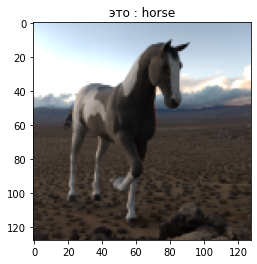

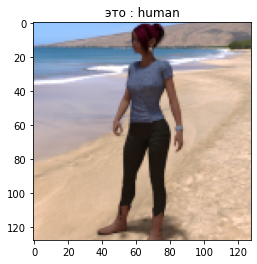

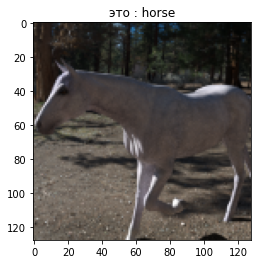

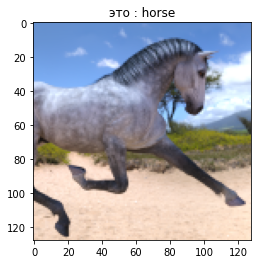

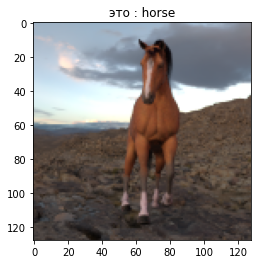

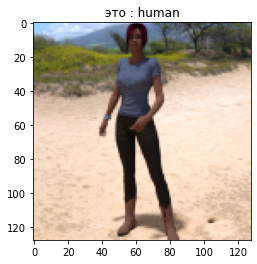

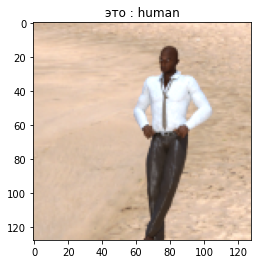

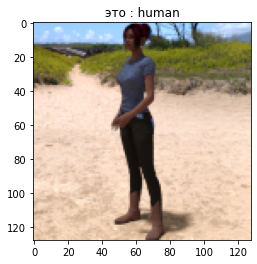

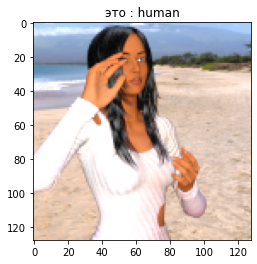

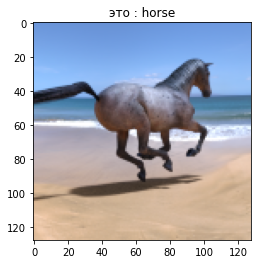

In [45]:
n = 2
for image, label in train_dataset.take(10):
    sample_image, sample_label = image, label

    x_test, y_label = image.numpy(), label.numpy()

    y_p = f_model.predict(x_test[:,:,:])
    y_pred = y_p.argmax(axis=-1)[n]
    plt.imshow(x_test[n,:,:])

    plt.title('это : '+ classes[y_pred])
    plt.show()